In [23]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.xarray
%matplotlib qt

# Centre Voltage Sweep

In [24]:
cen_v= pd.read_csv('./2019-06-29/phi0_daedalus_voltCenter_calib_2019-06-29_2.csv', comment="#")
cen_vn = cen_v[cen_v.Yfield>0]
cen_vp = cen_v[cen_v.Yfield<0]
cen_vp_coeff = np.polyfit(cen_vp.Yfield.values, cen_vp.V.values, 5)
cen_vn_coeff = np.polyfit(cen_vn.Yfield.values, cen_vn.V.values, 5)
cen_v_coeffs = np.asarray([cen_vn_coeff, cen_vp_coeff])
print(cen_v_coeffs)
cen_vp_fit = np.poly1d(cen_vp_coeff)
cen_vn_fit = np.poly1d(cen_vn_coeff)

[[ 4.16168895e+03 -3.11844226e+03  5.47011535e+02 -2.84592899e+01
  -1.86123341e+01  8.26244300e-03]
 [ 4.15146313e+03  3.09829665e+03  5.35103810e+02  2.63857442e+01
  -1.86952107e+01 -1.33786176e-02]]


### Change radial Polar files

In [47]:
def parse(volts):
    vp = pd.read_csv('./2019-06-30/%gvp_daedalus_radialPolar_calib_A000.0_2019-06-30_2.csv' % volts, comment='#')
    vn = pd.read_csv('./2019-06-30/%gvn_daedalus_radialPolar_calib_A000.0_2019-06-30_2.csv' % volts, comment='#')

    vp = vp.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
    vp = vp.assign(theta=lambda a: np.arctan2(a.Zfield, -a.Yfield)*180/np.pi)
    vp = vp.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

    vn = vn.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
    vn = vn.assign(theta=lambda a: np.arctan2(a.Zfield, a.Yfield)*180/np.pi)
    vn = vn.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

    vp_dv = {}
    vn_dv = {}
    for c in vp.columns[:]:
        vp_dv[c] = (["R"],vp[c])
        vn_dv[c] = (["R"],vn[c])
    vp_ds = xr.Dataset(vp_dv)
    vn_ds = xr.Dataset(vn_dv)

    vp_rp = vp[vp.R>0]
    vp_rn = vp[vp.R<0]
    vn_rp = vn[vn.R>0]
    vn_rn = vn[vn.R<0]

    vn_R_thetapos_coeff = np.polyfit(vn_rp.theta, vn_rp.R, 6)
    vn_R_thetaneg_coeff = np.polyfit(vn_rn.theta, vn_rn.R, 6)
    vn_R_thetapos = np.poly1d(vn_R_thetapos_coeff)
    vn_R_thetaneg = np.poly1d(vn_R_thetaneg_coeff)
    R_theta = vn_R_thetapos_coeff,vn_R_thetaneg_coeff
    print(R_theta)
    
    np.savetxt("./icarusCalibCsv/icarus_%gV_radial_polar_calib.csv" % volts, R_theta, delimiter=",")

    bmag_vp_rp_coeff = np.polyfit(vp[vp.R>0].R, vp[vp.R>0].Bmag, 10)
    bmag_vp_rp = np.poly1d(bmag_vp_rp_coeff)

    bmag_vp_rn_coeff = np.polyfit(vp[vp.R<0].R, vp[vp.R<0].Bmag, 10)
    bmag_vp_rn = np.poly1d(bmag_vp_rn_coeff)

    bmag_vn_rp_coeff = np.polyfit(vn[vn.R>0].R, vn[vn.R>0].Bmag, 10)
    bmag_vn_rp = np.poly1d(bmag_vn_rp_coeff)

    bmag_vn_rn_coeff = np.polyfit(vn[vn.R<0].R, vn[vn.R<0].Bmag, 10)
    bmag_vn_rn = np.poly1d(bmag_vn_rn_coeff)

    V0 = cen_vn_fit(bmag_vn_rp(0.0)) # Voltage used for radial scan
    Rpts_p = np.arange(0, 15, 0.1)
    Rpts_n = np.arange(-15, 0, 0.1)

    vcent_vp_rp = -V0/cen_vp_fit(-bmag_vp_rp(Rpts_p))
    vcent_vp_rn = -V0/cen_vp_fit(-bmag_vp_rn(Rpts_n))
    vcent_vn_rp = V0/cen_vn_fit(bmag_vn_rp(Rpts_p))
    vcent_vn_rn = V0/cen_vn_fit(bmag_vn_rn(Rpts_n))

    n = 10
    vcorr_vp_rp_coeff = np.polyfit(Rpts_p, vcent_vp_rp, n)
    vcorr_vp_rp = np.poly1d(vcorr_vp_rp_coeff)
    vcorr_vp_rn_coeff = np.polyfit(Rpts_n, vcent_vp_rn, n)
    vcorr_vp_rn = np.poly1d(vcorr_vp_rn_coeff)
    vcorr_vn_rp_coeff = np.polyfit(Rpts_p, vcent_vn_rp, n)
    vcorr_vn_rp = np.poly1d(vcorr_vn_rp_coeff)
    vcorr_vn_rn_coeff = np.polyfit(Rpts_n, vcent_vn_rn, n)
    vcorr_vn_rn = np.poly1d(vcorr_vn_rn_coeff)

    print(vcorr_vn_rp_coeff, '\n', vcorr_vp_rp_coeff, '\n', vcorr_vn_rn_coeff, '\n',vcorr_vp_rn_coeff)
    
    vcorr_coeffs = [vcorr_vn_rp_coeff, vcorr_vp_rp_coeff, vcorr_vn_rn_coeff,vcorr_vp_rn_coeff]
    np.savetxt("./icarusCalibCsv/icarus_%gV_volt_correction_calib.csv" % volts, vcorr_coeffs, delimiter=",")

In [48]:
parse(4)

(array([-1.98141495e-10,  4.93642006e-08, -4.35736352e-06,  1.80368305e-04,
       -3.93101361e-03,  1.61686644e-01, -1.78514000e-02]), array([1.79899603e-10, 4.49943059e-08, 3.95474449e-06, 1.60961952e-04,
       3.42514052e-03, 1.58093380e-01, 8.92014013e-02]))
[-8.39530610e-10  6.54616145e-08 -2.15128635e-06  3.84991374e-05
 -4.03796286e-04  2.48685069e-03 -8.68842329e-03  1.75279783e-02
 -1.97153979e-02  7.36274991e-03  9.99600879e-01] 
 [-9.14601717e-10  7.11385022e-08 -2.33368357e-06  4.17447862e-05
 -4.38756196e-04  2.72108106e-03 -9.65772431e-03  1.99271182e-02
 -2.29954233e-02  9.28471800e-03  1.00279430e+00] 
 [-7.18561225e-10 -5.74680517e-08 -1.94021442e-06 -3.57462166e-05
 -3.87170431e-04 -2.47437491e-03 -9.03306983e-03 -1.90195859e-02
 -2.22764410e-02 -8.75642606e-03  9.99144024e-01] 
 [-7.57567104e-10 -6.05690666e-08 -2.04557121e-06 -3.77406383e-05
 -4.10154100e-04 -2.63979180e-03 -9.76858065e-03 -2.09637340e-02
 -2.50861621e-02 -1.05618122e-02  1.00250455e+00]


In [25]:
vp = pd.read_csv('./2019-06-30/1vp_daedalus_radialPolar_calib_A000.0_2019-06-30_1.csv', comment='#')
vn = pd.read_csv('./2019-06-30/1vn_daedalus_radialPolar_calib_A000.0_2019-06-30_1.csv', comment='#')

vp = vp.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vp = vp.assign(theta=lambda a: np.arctan2(a.Zfield, -a.Yfield)*180/np.pi)
vp = vp.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

vn = vn.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vn = vn.assign(theta=lambda a: np.arctan2(a.Zfield, a.Yfield)*180/np.pi)
vn = vn.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

vp_dv = {}
vn_dv = {}
for c in vp.columns[:]:
    vp_dv[c] = (["R"],vp[c])
    vn_dv[c] = (["R"],vn[c])
vp_ds = xr.Dataset(vp_dv)
vn_ds = xr.Dataset(vn_dv)

vp_rp = vp[vp.R>0]
vp_rn = vp[vp.R<0]
vn_rp = vn[vn.R>0]
vn_rn = vn[vn.R<0]

vn_R_thetapos_coeff = np.polyfit(vn_rp.theta, vn_rp.R, 6)
vn_R_thetaneg_coeff = np.polyfit(vn_rn.theta, vn_rn.R, 6)
vn_R_thetapos = np.poly1d(vn_R_thetapos_coeff)
vn_R_thetaneg = np.poly1d(vn_R_thetaneg_coeff)
R_theta = vn_R_thetapos_coeff,vn_R_thetaneg_coeff
print(R_theta)

(array([-1.92548234e-10,  4.78121166e-08, -4.19621977e-06,  1.72609644e-04,
       -3.75802672e-03,  1.60201783e-01, -7.22839424e-03]), array([1.79993350e-10, 4.50573240e-08, 3.96599304e-06, 1.61750156e-04,
       3.45019773e-03, 1.58396944e-01, 9.46732568e-02]))


### Change radial polar calib filename

In [30]:
np.savetxt("./icarusCalibCsv/icarus_1V_radial_polar_calib.csv", R_theta, delimiter=",")

bmag_vp_rp_coeff = np.polyfit(vp[vp.R>0].R, vp[vp.R>0].Bmag, 10)
bmag_vp_rp = np.poly1d(bmag_vp_rp_coeff)

bmag_vp_rn_coeff = np.polyfit(vp[vp.R<0].R, vp[vp.R<0].Bmag, 10)
bmag_vp_rn = np.poly1d(bmag_vp_rn_coeff)

bmag_vn_rp_coeff = np.polyfit(vn[vn.R>0].R, vn[vn.R>0].Bmag, 10)
bmag_vn_rp = np.poly1d(bmag_vn_rp_coeff)

bmag_vn_rn_coeff = np.polyfit(vn[vn.R<0].R, vn[vn.R<0].Bmag, 10)
bmag_vn_rn = np.poly1d(bmag_vn_rn_coeff)

V0 = cen_vn_fit(bmag_vn_rp(0.0)) # Voltage used for radial scan
Rpts_p = np.arange(0, 15, 0.1)
Rpts_n = np.arange(-15, 0, 0.1)

vcent_vp_rp = -V0/cen_vp_fit(-bmag_vp_rp(Rpts_p))
vcent_vp_rn = -V0/cen_vp_fit(-bmag_vp_rn(Rpts_n))
vcent_vn_rp = V0/cen_vn_fit(bmag_vn_rp(Rpts_p))
vcent_vn_rn = V0/cen_vn_fit(bmag_vn_rn(Rpts_n))

n = 10
vcorr_vp_rp_coeff = np.polyfit(Rpts_p, vcent_vp_rp, n)
vcorr_vp_rp = np.poly1d(vcorr_vp_rp_coeff)
vcorr_vp_rn_coeff = np.polyfit(Rpts_n, vcent_vp_rn, n)
vcorr_vp_rn = np.poly1d(vcorr_vp_rn_coeff)
vcorr_vn_rp_coeff = np.polyfit(Rpts_p, vcent_vn_rp, n)
vcorr_vn_rp = np.poly1d(vcorr_vn_rp_coeff)
vcorr_vn_rn_coeff = np.polyfit(Rpts_n, vcent_vn_rn, n)
vcorr_vn_rn = np.poly1d(vcorr_vn_rn_coeff)

print(vcorr_vn_rp_coeff, '\n', vcorr_vp_rp_coeff, '\n', vcorr_vn_rn_coeff, '\n',vcorr_vp_rn_coeff)

[-3.67441105e-10  3.04517578e-08 -1.06050036e-06  2.00542565e-05
 -2.21551898e-04  1.43097670e-03 -5.21368764e-03  1.09866783e-02
 -1.27999248e-02  4.79009479e-03  9.99691763e-01] 
 [-4.57474711e-10  3.63031403e-08 -1.21763788e-06  2.23064811e-05
 -2.40170704e-04  1.52155238e-03 -5.48153192e-03  1.15800780e-02
 -1.39902795e-02  6.00777421e-03  1.01573950e+00] 
 [-2.32153622e-10 -2.05084613e-08 -7.54213240e-07 -1.49340511e-05
 -1.71257899e-04 -1.13596345e-03 -4.19186403e-03 -8.94005027e-03
 -1.09934534e-02 -4.18782456e-03  9.99838892e-01] 
 [-4.33536865e-10 -3.42722831e-08 -1.15293275e-06 -2.13358393e-05
 -2.33831937e-04 -1.52082325e-03 -5.67570472e-03 -1.23909907e-02
 -1.53233834e-02 -6.57179544e-03  1.01514511e+00]


### Change filename

In [31]:
vcorr_coeffs = [vcorr_vn_rp_coeff, vcorr_vp_rp_coeff, vcorr_vn_rn_coeff,vcorr_vp_rn_coeff]
np.savetxt("./icarusCalibCsv/icarus_1V_volt_correction_calib.csv", vcorr_coeffs, delimiter=",")

In [32]:
plt.plot(Rpts_p, vcent_vp_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vp_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

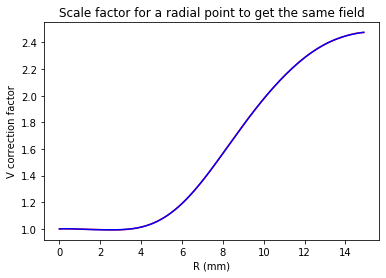

In [28]:
plt.plot(Rpts_p, vcent_vn_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vn_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

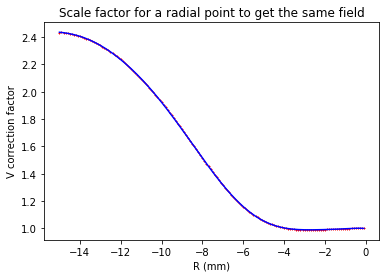

In [29]:
plt.plot(Rpts_n, vcent_vp_rn, 'r+', markersize = 2)
plt.plot(Rpts_n, vcorr_vp_rn(Rpts_n), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

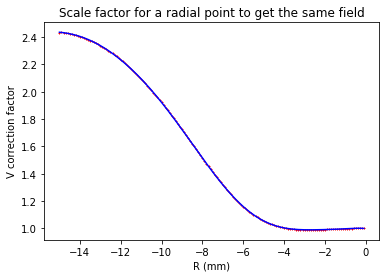

In [30]:
plt.plot(Rpts_n, vcent_vn_rn, 'r+', markersize = 2)
plt.plot(Rpts_n, vcorr_vn_rn(Rpts_n), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')